# 2018.11.01: Network inference from time series of categorical variables

In [1]:
import sys
import numpy as np
import timeit
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
%matplotlib inline
import multiprocessing

import inference

In [2]:
# setting parameter:
np.random.seed(1)

n = 20 # number of positions
m = 5 # number of values at each position
l = int(1*((n*m)**2)) # number of samples
g = 4.

In [3]:
w0 = inference.generate_interactions(n,m,g)

In [4]:
def itab(n,m):    
    i1 = np.zeros(n)
    i2 = np.zeros(n)
    for i in range(n):
        i1[i] = i*m
        i2[i] = (i+1)*m

    return i1.astype(int),i2.astype(int)

In [5]:
def generate_sequences(w,n,m,l): 
    i1tab,i2tab = itab(n,m)    
   
    # initial s (categorical variables)
    s_ini = np.random.randint(0,m,size=(l,n)) # integer values
    #print(s_ini)

    # onehot encoder 
    enc = OneHotEncoder(n_values=m)
    s = enc.fit_transform(s_ini).toarray()
    #print(s) 

    ntrial = 20*m

    for t in range(l-1):
        h = np.sum(s[t,:]*w[:,:],axis=1)
        for i in range(n):
            i1,i2 = i1tab[i],i2tab[i]
                
            k = np.random.randint(0,m)              
            for itrial in range(ntrial):            
                k2 = np.random.randint(0,m)                
                while k2 == k:
                    k2 = np.random.randint(0,m)
                               
                if np.exp(h[i1+k2]- h[i1+k]) > np.random.rand():
                    k = k2
            
            s[t+1,i1:i2] = 0.
            s[t+1,i1+k] = 1.
            
    return s  

In [13]:
#def generate_sequences_MPC(w,n,m,l):
start_time = timeit.default_timer()

w = w0.copy()

i1tab,i2tab = itab(n,m)    
nPC = min(multiprocessing.cpu_count(),n)

#-------------------------------------
def update_states(i):
    i1,i2 = i1tab[i],i2tab[i]
    k = np.random.randint(0,m)              
    for itrial in range(ntrial):            
        k2 = np.random.randint(0,m)                
        while k2 == k:
            k2 = np.random.randint(0,m)

        if np.exp(h[i1+k2]- h[i1+k]) > np.random.rand():
            k = k2

    #s[t+1,i1:i2] = 0.
    #s[t+1,i1+k] = 1. 
    return k
#------------------------------------

# initial s (categorical variables)
s_ini = np.random.randint(0,m,size=(l,n)) # integer values
#print(s_ini)

# onehot encoder 
enc = OneHotEncoder(n_values=m)
s = enc.fit_transform(s_ini).toarray()
#print(s) 

ntrial = 20*m

for t in range(l-1):
    h = np.sum(s[t,:]*w[:,:],axis=1)

    #for i in range(n):            
    #    update_states(i)
    pool = multiprocessing.Pool(processes=nPC)
    res = pool.map(update_states,list(range(n)))
    pool.close()
    
    for i in range(n):
        k = res[i]
        i1,i2 = i1tab[i],i2tab[i]
        s[t+1,i1:i2] = 0.
        s[t+1,i1+k] = 1. 

#return s  

stop_time = timeit.default_timer()
run_time = stop_time-start_time
print('run_time:', run_time)

('run_time:', 437.8355190753937)


('run_time:', 8.59586501121521)
('MSE by multiplicative update:', 0.006463854600551988)


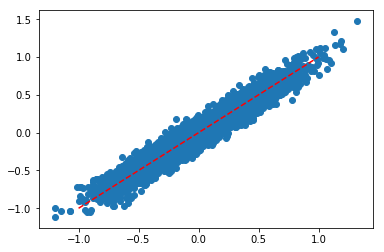

In [14]:
start_time = timeit.default_timer()

w = inference.fit_multiplicative(s,n,m)

stop_time = timeit.default_timer()
run_time = stop_time-start_time
print('run_time:', run_time)

plt.scatter(w0,w)
plt.plot([-1.0,1.0],[-1.0,1.0],'r--')
mse = ((w0-w)**2).mean()
print('MSE by multiplicative update:',mse)

In [8]:
#pool = multiprocessing.Pool(processes=nPC)
#res = pool.map(test_MPC,list(range(n)))
#pool.close()

#start_time = timeit.default_timer()

#s = generate_sequences(w0,n,m,l)

#stop_time = timeit.default_timer()
#run_time = stop_time-start_time
#print('run_time:', run_time)

In [9]:
#w = inference.fit_multiplicative(s,n,m)

In [10]:
#plt.scatter(w0,w)
#plt.plot([-1.0,1.0],[-1.0,1.0],'r--')
#mse = ((w0-w)**2).mean()
#print('MSE by multiplicative update:',mse)